In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports.py

/work2/08258/akumar01/maverick2/env/lib64/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


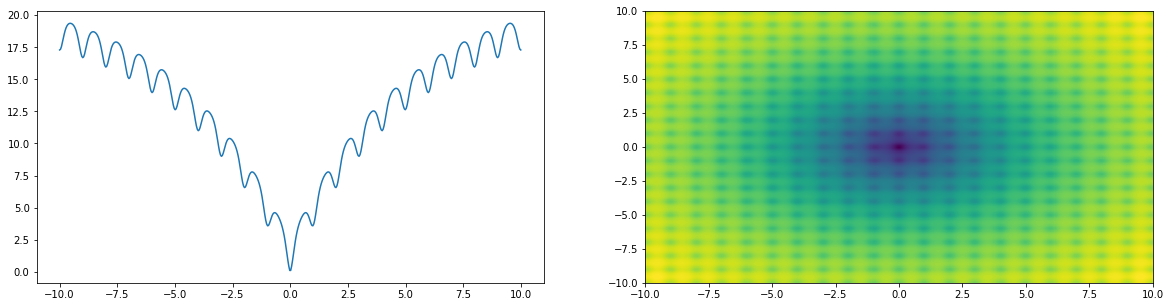

/work2/08258/akumar01/maverick2/env/lib64/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


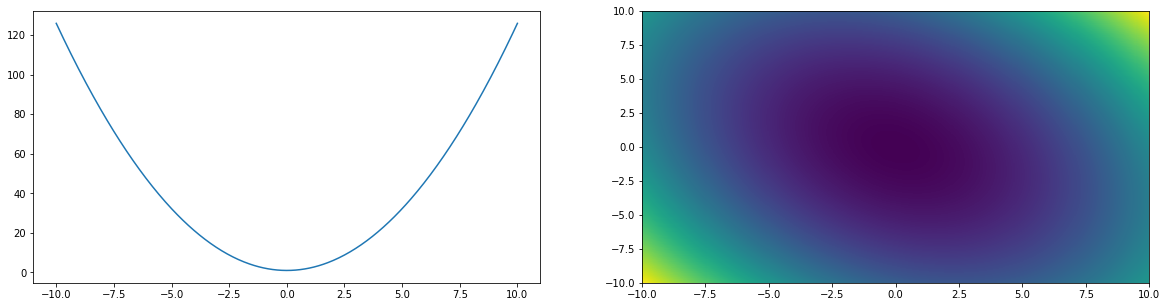

In [3]:
x = torch.linspace(-10, 10, 500)
y = torch.linspace(-10, 10, 500)
# x = torch.linspace(-500, 500, 1000)
# y = torch.linspace(-500, 500, 1000)
xm, ym = torch.meshgrid(x, y)

# for optim_fn in [ackley, rastrigin, myrastrigin, xin_she_yang, schwefel, zakharov, schaffer]:
for optim_fn in [ackley, zakharov]:
    plt.figure(figsize=(20, 5))
    plt.subplot(121)
    plt.plot(x, optim_fn(x[:, None]))
    plt.subplot(122)
    z = torch.stack([xm, ym], dim=-1)
    z = optim_fn(z)
    plt.pcolormesh(x, y, z)
    plt.show()
    

In [70]:

def grad_of(pop_final):
    pop_final = pop_final.clone().requires_grad_()
    val = ackley(pop_final)
    val.sum().backward()
    return pop_final.grad

In [3]:
from paper_meta import *

In [4]:

optim_fn = ackley
n_gen = 500


algo2algo_fn['fmr'] = partial(algo2algo_fn['fmr'], mr=.2)

data = {}
for algo in tqdm(['nsmr', 'gsmr', 'gsmr_avg', 'fmr']):
    data[algo] = {'fits': [], 'mrs': []}
    for seed in (range(9)):
        do_seed(seed)
        pop = torch.randn(101, 100)*10
        
        a = algo2algo_fn[algo](pop, optim_fn, n_gen)
        pops, fits, mrs = a[:3]
        fits = fits.min(dim=-1).values
        while mrs.ndim>1:
            mrs = mrs.log().mean(dim=-1).exp()
        data[algo]['fits'].append(fits)
        data[algo]['mrs'].append(mrs)
    data[algo]['fits'] = torch.stack(data[algo]['fits'])
    data[algo]['mrs'] = torch.stack(data[algo]['mrs'])


100%|██████████| 4/4 [00:11<00:00,  2.90s/it]


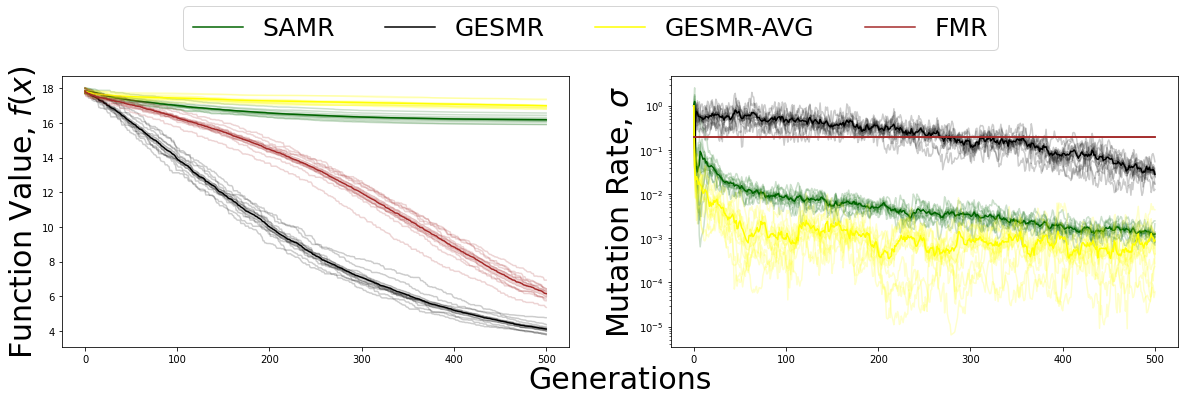

In [5]:

fig, axs = plt.subplots(1,2, figsize=(20, 5))
ax = fig.add_subplot(111)
viz.empty_ax(ax)
plt.xlabel('Generations', fontsize=30)
for algo in ['nsmr', 'gsmr', 'gsmr_avg', 'fmr']:
    plt.sca(axs[0])
    viz.plot_mean_std(data[algo]['fits'], name=algo2label[algo], c=algo2color[algo], use_std_error=True)
    plt.legend().remove()
    plt.sca(axs[1])
    viz.plot_mean_std(data[algo]['mrs'], name=algo2label[algo], c=algo2color[algo], use_std_error=True)
    plt.legend().remove()
    
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.yscale('log')
    
ax.legend(handles, labels, fontsize=25, ncol=4, bbox_to_anchor=(.85, 1.3))

plt.sca(axs[0])
plt.ylabel('Function Value, $f(x)$', fontsize=30)
plt.sca(axs[1])
plt.ylabel('Mutation Rate, $\sigma$', fontsize=30)

plt.savefig('results/premature.png', dpi=300, bbox_inches = 'tight')


torch.Size([2])
torch.Size([9, 10000, 2])
torch.Size([9, 10000])


/work2/08258/akumar01/maverick2/env/lib64/python3.6/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


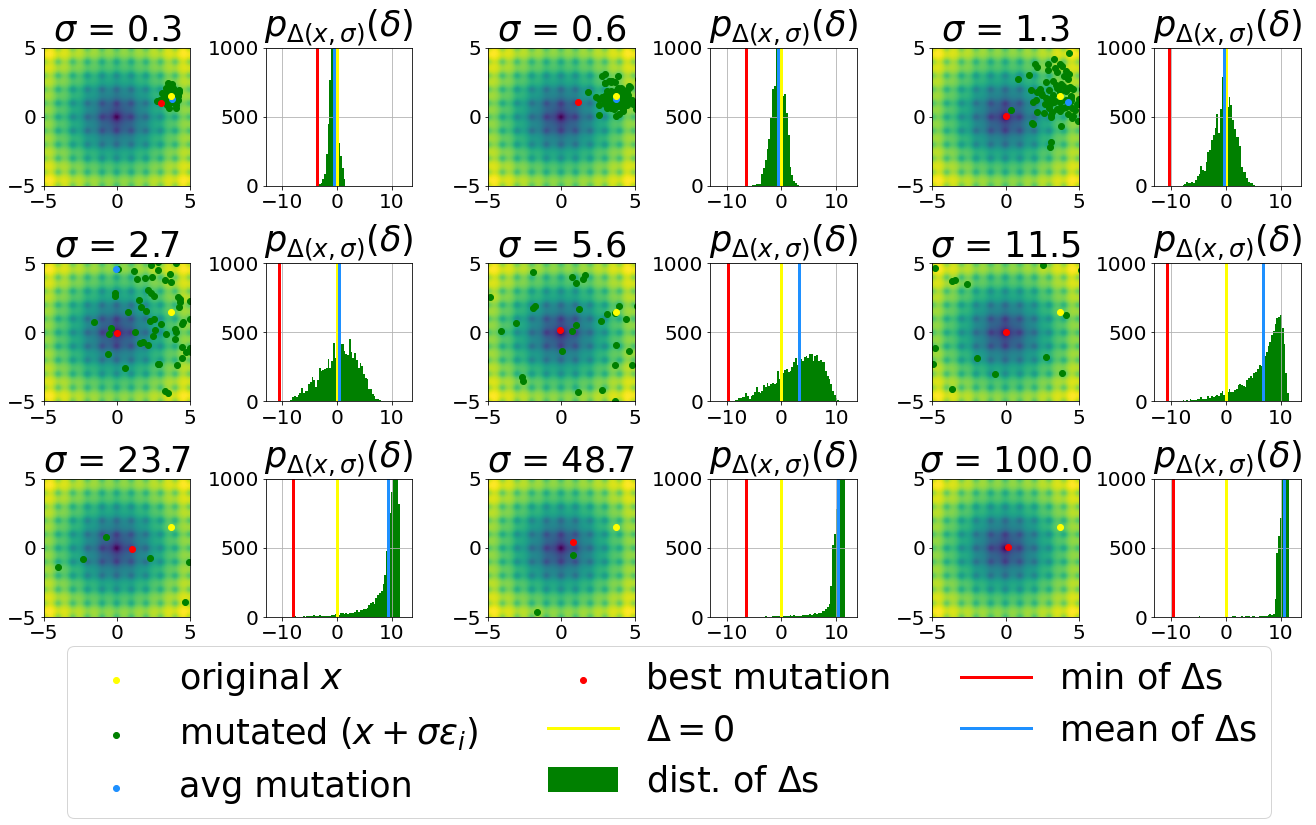

In [3]:
def viz_temp(n_rows, n_cols, log_mr_low, log_mr_high, optim_fn):
    x = torch.linspace(-5, 5, 500)
    y = torch.linspace(-5, 5, 500)
    xm, ym = torch.meshgrid(x, y)
    z = torch.stack([xm, ym], dim=-1)
    z = optim_fn(z)
    
    mrs = torch.logspace(log_mr_low, log_mr_high, n_rows*n_cols)
#     x = torch.tensor([5., 5.])
    x = torch.randn(2)
    x = x/x.norm()*4.
    
    n_samples = 10000
    n_samples_display = 100
    
    x, xmut, fit_diff = get_mrs_fitness(x, mrs, optim_fn, n_samples=n_samples)
    
    print(x.shape)
    print(xmut.shape)
    print(fit_diff.shape)
#     best_mrs = mrs[fit_diff.min(dim=-1).values.argsort()]

    fig, axs = plt.subplots(n_rows, n_cols*2, figsize=(20, 12))
    ax = fig.add_subplot(111)
    viz.empty_ax(ax)
    
    i = 0
    for i_row in range(n_rows):
        for i_col in range(0, n_cols*2, 2):
            best_xmut = xmut[i, fit_diff[i].argmin(dim=-1)]
            avg_xmut = xmut[i, (fit_diff[i]-fit_diff[i].mean()).abs().argmin(dim=-1)]
            
            plt.sca(axs[i_row, i_col])
            plt.title(f'$\sigma$ = {mrs[i]:.1f}', fontsize=35)
            plt.pcolormesh(xm, ym, z)
            
            smp_rate = n_samples//n_samples_display
            plt.scatter(*xmut[i].numpy()[::smp_rate].T, c='green', label='mutated ($x+\sigma \epsilon_i$)')
            plt.scatter(*best_xmut.numpy(), c='r', label='best mutation')
            plt.scatter(*avg_xmut.numpy(), c='dodgerblue', label='avg mutation')
            plt.scatter(*x.numpy(), c='yellow', label='original $x$')
            
            plt.xlim(xm.min(), xm.max())
            plt.ylim(ym.min(), ym.max())
#             if i_row==n_rows-1 and i_col==n_cols//2*2:
#                 plt.legend(fontsize=10, bbox_to_anchor=(.05, -.1), loc='upper left')
            plt.locator_params(axis='y', nbins=2); plt.locator_params(axis='x', nbins=2)
            plt.xticks(fontsize=20); plt.yticks(fontsize=20)
            
            plt.sca(axs[i_row, i_col+1])
            plt.title('$p_{\Delta(x, \sigma)}(\delta)$', fontsize=35)
            bins = np.linspace(fit_diff.min(), fit_diff.max(), 70)
            plt.hist(fit_diff[i].numpy(), bins=bins, color='green', label='dist. of $\Delta$s')
            plt.axvline(0, c='yellow', label='$\Delta=0$', linewidth=3)
            plt.axvline(fit_diff[i].min().numpy(), c='r', label='min of $\Delta$s', linewidth=3)
#             plt.axvline(fit_diff[i].max().numpy(), c='r', label='max of $\Delta$s', linewidth=3)
            plt.axvline(fit_diff[i].mean().numpy(), c='dodgerblue', label='mean of $\Delta$s', linewidth=3)
            r = fit_diff.max()-fit_diff.min()
            plt.xlim(fit_diff.min()-.1*r, fit_diff.max()+.1*r)
            plt.ylim(0, 1000)
            i+=1
            plt.locator_params(axis='y', nbins=2); plt.locator_params(axis='x', nbins=2)
            plt.xticks(fontsize=20); plt.yticks(fontsize=20)
            plt.grid()
            
#             if i_row==n_rows-1 and i_col==n_cols//2*2:
#                 plt.legend(fontsize=10, bbox_to_anchor=(.25, -.1), loc='upper left')

    h, l = [], []
    handles, labels = axs[-1, -2].get_legend_handles_labels()
    h.extend(handles); l.extend(labels)
    handles, labels = axs[-1, -1].get_legend_handles_labels()
    h.extend(handles); l.extend(labels)
#     h = np.array(h)[np.array([3, 0, 2, 1, 4, 8, 7, 5, 6])] #with max lol ugly code
#     l = np.array(l)[np.array([3, 0, 2, 1, 4, 8, 7, 5, 6])]
    h = np.array(h)[np.array([3, 0, 2, 1, 4, 7, 5, 6])]
    l = np.array(l)[np.array([3, 0, 2, 1, 4, 7, 5, 6])]
    ax.legend(h, l, fontsize=35, ncol=3, bbox_to_anchor=(.99, -.02),)

    plt.tight_layout()

do_seed(1)
viz_temp(3, 3, -.5, 2., ackley)
plt.savefig('results/landscape_mut.png', dpi=300, bbox_inches='tight')
plt.show()


# Sample Mutation Rates Delta Fitness Distributions

In [7]:
mrs = torch.logspace(-1, 1.5, 16)
x = torch.randn(10000, 2)
x, xmut, fit_diff = get_mrs_fitness(x, mrs, ackley)
print(fit_diff.shape)
best_mrs = mrs[fit_diff.min(dim=-1).values.argsort()]

torch.Size([16, 10000])


In [8]:
fit_diff.min(), fit_diff.max()

(tensor(-7.3083), tensor(22.1802))

In [9]:
mrs = torch.logspace(-1, 1.5, 4)
x = torch.randn(10000, 2)
x, xmut, fit_diff = get_mrs_fitness(x, mrs, ackley)
print(fit_diff.shape)
best_mrs = mrs[fit_diff.min(dim=-1).values.argsort()]

torch.Size([4, 10000])


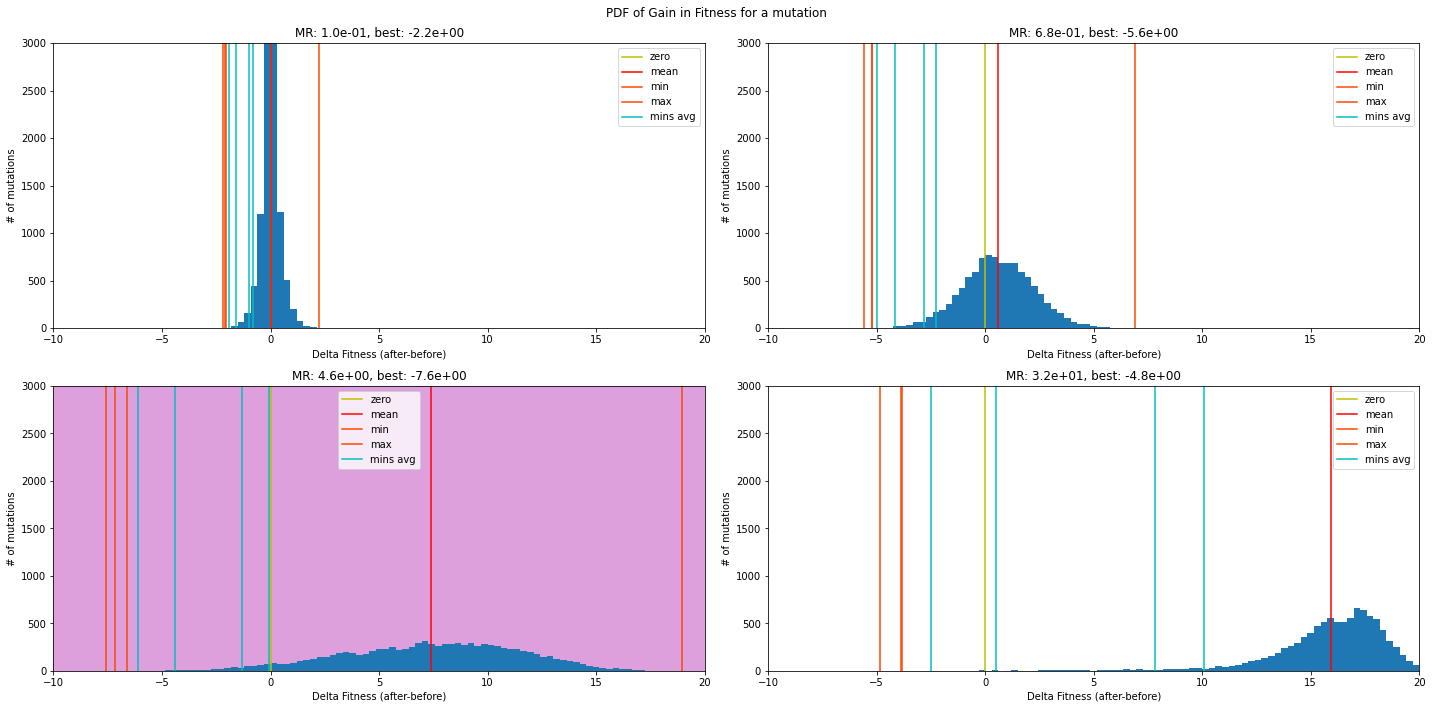

In [10]:
fig, axs = viz_mrs_fit_hists(mrs, x, xmut, fit_diff, (2,2))
axs.flatten()[fit_diff.min(dim=-1).values.argmin()].set_facecolor('plum')
fig.show()

# Mutation Rate vs Delta Fitness Distributions

In [4]:
def calc_fd_bins_ns(mrs, fit_diff, fd_bins):
    ns = []
    for i, mr in enumerate(mrs):
        fd = fit_diff[i]
    #     n, _, chart = plt.hist(fd.cpu().numpy(), bins=bins)
        n, _  = np.histogram(fd.cpu().numpy(), bins=fd_bins)
        ns.append(n)
    ns = np.stack(ns)
    return ns
def calc_fd_bins_ns_with_pop(x, optim_fn, 
                             log_mr_low=-1, log_mr_high=1.5, n_mrs=100,
                             fd_bin_low=-10, fd_bin_high=20, n_fd_bins=100):
    mrs = torch.logspace(log_mr_low, log_mr_high, n_mrs)
    x, xmut, fit_diff = get_mrs_fitness(x, mrs, optim_fn, n_samples=10)
    best_mrs = mrs[fit_diff.min(dim=-1).values.argsort()]
    
    fd_bins = np.linspace(fd_bin_low, fd_bin_high, n_fd_bins+1)
    ns = calc_fd_bins_ns(mrs, fit_diff, fd_bins)
    fd_bins = np.linspace(fd_bin_low, fd_bin_high, n_fd_bins)
    return mrs, fd_bins, ns, fit_diff
"""
WHEN YOU'RE BACK: get these shapes to work out and batch everything
then we can run this for avg of mins case, etc.
"""

"\nWHEN YOU'RE BACK: get these shapes to work out and batch everything\nthen we can run this for avg of mins case, etc.\n"

In [5]:
do_seed(0)
x = torch.randn(50, 1000, 2)
mrs, fd_bins, ns, fit_diff = calc_fd_bins_ns_with_pop(x, ackley, 
                             log_mr_low=-1, log_mr_high=1.5, n_mrs=100, 
                             fd_bin_low=-10, fd_bin_high=20, n_fd_bins=100)
mrs.shape, fd_bins.shape, ns.shape, fit_diff.shape

(torch.Size([100]), (100,), (100, 100), torch.Size([100, 10, 50, 1000]))

In [6]:
do_seed(0)
mrs = torch.logspace(-1, 1.5, 100)
x = torch.randn(10000, 2)
x, xmut, fit_diff = get_mrs_fitness(x, mrs, ackley, n_samples=10)
print(fit_diff.shape)
best_mrs = mrs[fit_diff.min(dim=-1).values.argsort()]

torch.Size([100, 10, 10000])


In [7]:
fd_bins = np.linspace(-10, 20, 101)
ns = calc_fd_bins_ns(mrs, fit_diff, fd_bins)
fd_bins = np.linspace(-10, 20, 100)
# fd_bins = np.linspace(-50, 100, 101)
# ns = calc_fd_bins_ns(fit_diff, fd_bins)
# fd_bins = np.linspace(-50, 100, 100)

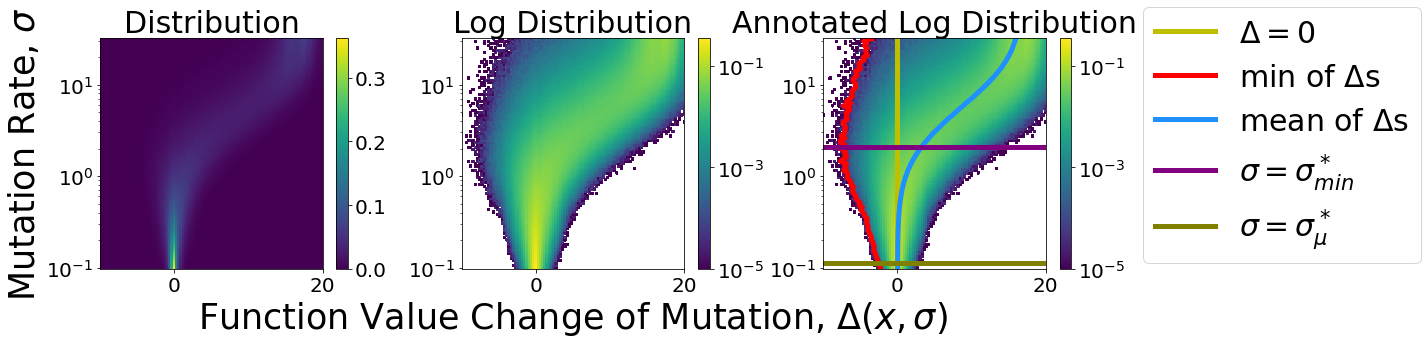

In [8]:
fig, axs = viz_mrs_performance(mrs, fd_bins, ns, fit_diff, True)
plt.savefig('results/curve_template.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
from paper_meta import *


In [10]:

kwargs = np.empty((4, 3), dtype=object)
for i, optim_fn in enumerate([ackley, rastrigin, sphere, lin_fn]):
    for ii, n_dim in enumerate([2, 10, 100]):
        kwargs[i, ii] = {
            'optim_fn': optim_fn,
            'log_mr_low':-1.3, 'log_mr_high':1.5, 'n_mrs':100, 
            'fd_bin_low':-10, 'fd_bin_high':20, 'n_fd_bins':100
        }
kwargs[0, 1]['log_mr_high'] = 1
kwargs[0, 2]['log_mr_high'] = .3


kwargs[1, 0]['log_mr_high'] = 2.
kwargs[1, 1]['log_mr_high'] = 1.2
kwargs[1, 2]['log_mr_high'] = .5
        
    
kwargs[2, 1]['log_mr_high'] = .7
kwargs[2, 2]['log_mr_high'] = 0
    
kwargs[3, 1]['log_mr_low'] = 0
kwargs[3, 1]['log_mr_high'] = 2
kwargs[3, 2]['log_mr_low'] = 1
kwargs[3, 2]['log_mr_high'] = 3
# for ii, n_dim in enumerate([2, 10, 100]):
#         'fd_bin_low':-50, 'fd_bin_high':100, 'n_fd_bins':100

/work2/08258/akumar01/maverick2/evolved-neuroevolution/analysis.py:77: RuntimeWarning: invalid value encountered in true_divide
  plt.pcolormesh(a, b, ns.T/ns.sum(axis=-1), shading='auto',


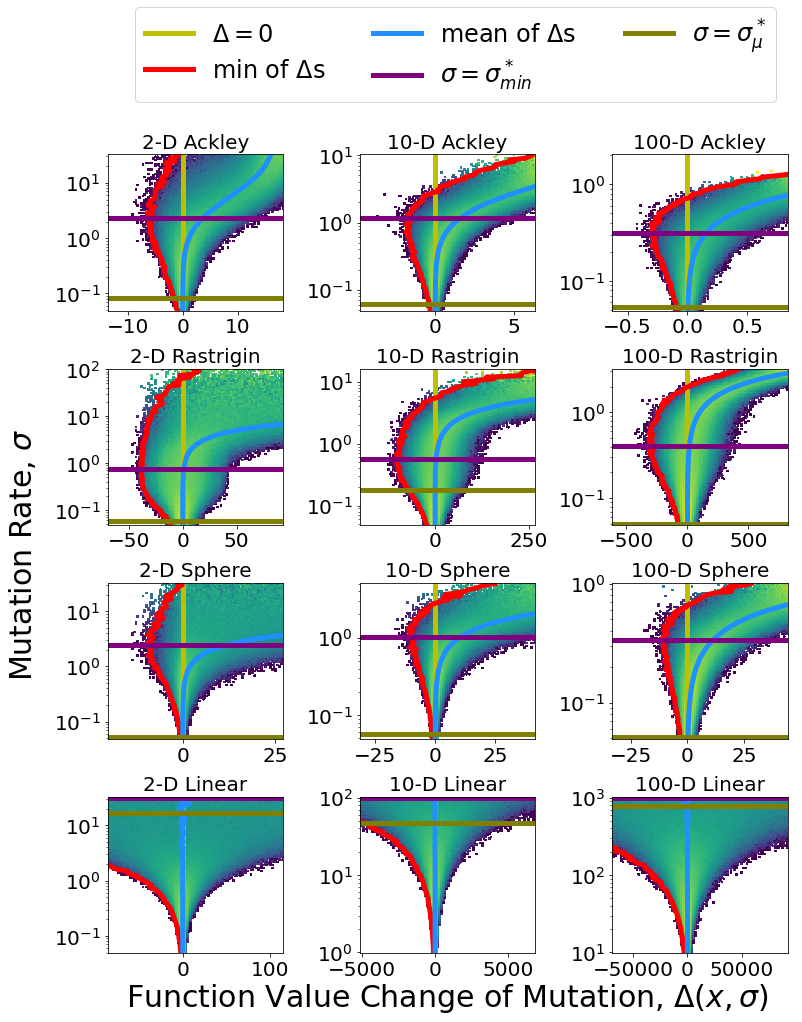

In [11]:
do_seed(0)
fig, axs = plt.subplots(4, 3, figsize=(12, 15), facecolor='white')
ax = fig.add_subplot(111)
viz.empty_ax(ax)

for i, optim_fn in enumerate([ackley, rastrigin, sphere, lin_fn]):
    for ii, n_dim in enumerate([2, 10, 100]):
        
#         if not (ii==0 and i==0):
#             continue
        x = torch.randn(1000, n_dim)
        x, xmut, fit_diff = get_mrs_fitness(x, mrs, optim_fn, n_samples=10)
        a = fit_diff.min().abs().item()
        kwargs[i, ii]['fd_bin_low']  = -1.5*a
        kwargs[i, ii]['fd_bin_high'] = +2.0*a
        
        mrs, fd_bins, ns, fit_diff = calc_fd_bins_ns_with_pop(x, **kwargs[i, ii])
        plt.sca(axs[i, ii])
        handles, labels = draw_mrs_performance(mrs, fd_bins, ns, fit_diff, top_legend=True, cbar=False)
        plt.legend().remove()
        plt.title(f'{n_dim}-D {optim_fn2label[optim_fn]}', fontsize=20)

plt.sca(ax)
plt.ylabel('Mutation Rate, $\sigma$', fontsize=30, labelpad=50)
plt.sca(ax)
plt.xlabel('Function Value Change of Mutation, $\Delta(x, \sigma)$', fontsize=30, labelpad=15)
ax.legend(handles, labels, fontsize=24, bbox_to_anchor=(1, 1.2), ncol=3)

plt.tight_layout()

plt.savefig('results/curves.png', dpi=300, bbox_inches='tight')
plt.show()



In [23]:
x = torch.randn(1000, 2)
mrs = torch.logspace(-1, 1, 100)
x, xmut, fit_diff = get_mrs_fitness(x, mrs, sphere, n_samples=10)

In [24]:
fit_diff.shape, mrs.shape

(torch.Size([100, 10, 1000]), torch.Size([100]))

(-30.0, 30.0)

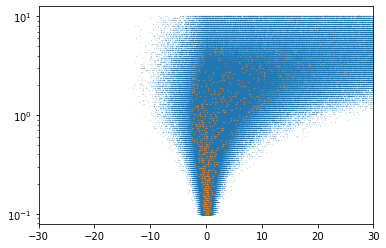

In [28]:
plt.scatter(fit_diff.flatten().numpy(), mrs.repeat(10, 1000, 1).permute(2, 0, 1).flatten().numpy(), s=.01)
plt.scatter(fit_diff[:, :, 30].flatten().numpy(), mrs.repeat(10, 1, 1).permute(2, 0, 1).flatten().numpy(), s=.1)
plt.yscale('log')
plt.xlim(-30, 30)

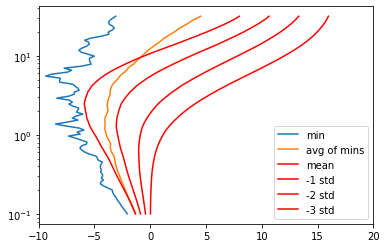

In [36]:
def viz_mr_min_std(mrs, fit_diff):
    a = fit_diff.min(dim=-1).values
    plt.plot(a, mrs, label='min')
    a = fit_diff.reshape(100, 100, 100).min(dim=-1).values.mean(dim=-1)
    plt.plot(a, mrs, label='avg of mins')

    a = fit_diff.mean(dim=-1)
    plt.plot(a, mrs, c='r', label='mean')
    a = fit_diff.mean(dim=-1)-fit_diff.std(dim=-1)
    plt.plot(a, mrs, c='r', label='-1 std')
    a = fit_diff.mean(dim=-1)-2*fit_diff.std(dim=-1)
    plt.plot(a, mrs, c='r', label='-2 std')
    a = fit_diff.mean(dim=-1)-3*fit_diff.std(dim=-1)
    plt.plot(a, mrs, c='r', label='-3 std')

    plt.legend()
    plt.xlim(-10, 20)
    plt.yscale('log')
    return plt.gcf()
viz_mr_min_std(mrs, fit_diff).show()

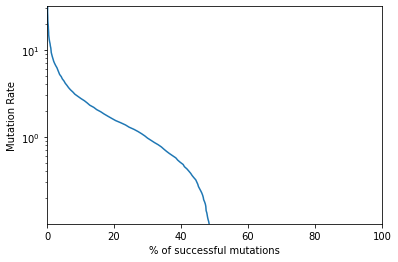

In [24]:
def viz_mr_percent(mrs, x, xmut, fit_diff):
    plt.plot((fit_diff<0).sum(dim=-1)/fit_diff.shape[-1]*100, mrs)
    plt.yscale('log')
    plt.ylabel('Mutation Rate'); plt.xlabel('% of successful mutations')
    plt.ylim(mrs.min(), mrs.max())
    plt.xlim(0,100)
viz_mr_percent(mrs, x, xmut, fit_diff)

Text(0.5, 0, '% successful mutation')

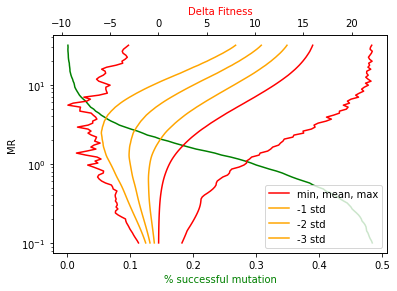

In [47]:
fig, ax1 = plt.subplots()
plt.yscale('log')

ax2 = ax1.twiny()
# a = fit_diff.min(dim=-1).values.min().abs().item()
# ax2.set_xlim(-a, a)
ax1.plot((fit_diff<0).sum(dim=-1)/fit_diff.shape[-1], mrs, c='g')


ax2.plot(fit_diff.mean(dim=-1), mrs, 'r-', label='min, mean, max')
ax2.plot(fit_diff.min(dim=-1).values, mrs, 'r-')
ax2.plot(fit_diff.max(dim=-1).values, mrs, 'r-')

a = fit_diff.mean(dim=-1)-fit_diff.std(dim=-1)
ax2.plot(a, mrs, c='orange', label='-1 std')
a = fit_diff.mean(dim=-1)-2*fit_diff.std(dim=-1)
ax2.plot(a, mrs, c='orange', label='-2 std')
a = fit_diff.mean(dim=-1)-3*fit_diff.std(dim=-1)
ax2.plot(a, mrs, c='orange', label='-3 std')


plt.legend()
ax1.set_ylabel('MR')
ax2.set_xlabel('Delta Fitness', color='r')
ax1.set_xlabel('% successful mutation', color='g')

In [141]:
mrs = torch.logspace(-1, 1.5, 32)
x = torch.randn(10000, 2)
x, xmut, fit_diff = get_mrs_fitness(x, mrs, ackley)
print(fit_diff.shape)

torch.Size([32, 10000])


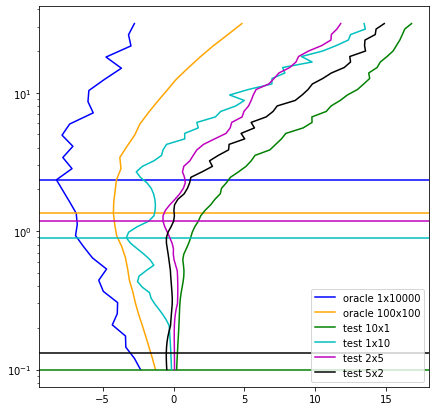

In [142]:

plt.figure(figsize=(7,7))
a = fit_diff.min(dim=-1).values
plt.plot(a, mrs, label='oracle 1x10000', c='b')
plt.axhline(mrs[a.argmin()], c='b')
a = fit_diff.reshape(-1, 100, 100).min(dim=-1).values.mean(dim=-1)
plt.plot(a, mrs, label='oracle 100x100', c='orange')
plt.axhline(mrs[a.argmin()], c='orange')


mrs = torch.logspace(-1, 1.5, 64)
x = torch.randn(10, 2)
x, xmut, fit_diff = get_mrs_fitness(x, mrs, ackley)
a = fit_diff.reshape(-1, 10, 1).min(dim=-1).values.mean(dim=-1)
plt.plot(a, mrs, label='test 10x1', c='g')
plt.axhline(mrs[a.argmin()], c='g')
x = torch.randn(10, 2)
x, xmut, fit_diff = get_mrs_fitness(x, mrs, ackley)
a = fit_diff.reshape(-1, 1, 10).min(dim=-1).values.mean(dim=-1)
plt.plot(a, mrs, label='test 1x10', c='c')
plt.axhline(mrs[a.argmin()], c='c')
x = torch.randn(10, 2)
x, xmut, fit_diff = get_mrs_fitness(x, mrs, ackley)
a = fit_diff.reshape(-1, 2, 5).min(dim=-1).values.mean(dim=-1)
plt.plot(a, mrs, label='test 2x5', c='m')
plt.axhline(mrs[a.argmin()], c='m')
x = torch.randn(10, 2)
x, xmut, fit_diff = get_mrs_fitness(x, mrs, ackley)
a = fit_diff.reshape(-1, 5, 2).min(dim=-1).values.mean(dim=-1)
plt.plot(a, mrs, label='test 5x2', c='k')
plt.axhline(mrs[a.argmin()], c='k')

plt.legend()
plt.yscale('log')